<p style="font-family:Roboto; font-size: 28px; color: magenta"> Python for NLP: Multi-Data-Type Classification</p>

In [25]:
'''Text classification is one of the most common natural language processing tasks'''

'Text classification is one of the most common natural language processing tasks'

In [26]:
'''
 How to create a text classification system that classifies user reviews regarding different business,
 into one of the three predefined categories i.e. "good", "bad", and "average"
'''

'\n How to create a text classification system that classifies user reviews regarding different business,\n into one of the three predefined categories i.e. "good", "bad", and "average"\n'

In [27]:
'''CSV file. The dataset contains multiple files, but we are only interested in the yelp_review.csv file.
The file contains more than 5.2 million reviews 
about different businesses, including restaurants, bars, dentists, doctors, beauty salons, etc

For our purposes we will only be using the first 50,000 records to train our model.
''' 

'CSV file. The dataset contains multiple files, but we are only interested in the yelp_review.csv file.\nThe file contains more than 5.2 million reviews \nabout different businesses, including restaurants, bars, dentists, doctors, beauty salons, etc\n\nFor our purposes we will only be using the first 50,000 records to train our model.\n'

<p style="font-family:Roboto; font-size: 28px; color: magenta"> Importing Required Libraries</p>

In [79]:
from tensorflow.keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer 
from keras.layers import Input
from keras.layers import Concatenate

import pandas as pd
import numpy as np
import re

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Importing and Analyzing the Dataset</p>

In [29]:
# yelp_reviews = pd.read_csv("./data/yelp_academic_dataset_review.csv")
# # Slice rows (e.g., rows 0 to 50000)
# sliced_df = yelp_reviews.iloc[0:50000]

# # Save the sliced data to a new CSV file
# sliced_df.to_csv('sliced_yelp_reviews.csv', index=False)
yelp_reviews = pd.read_csv("./data/sliced_yelp_reviews.csv")

In [30]:
'''The dataset contains a column Stars that contains ratings for different businesses. 
The "Stars" column can have values between 1 and 5. We will simplify our problem 
by converting the numerical values for the reviews into categorical ones.'''
bins = [0,1,3,5]
review_names = ['bad', 'average', 'good']
# The pd.cut function in pandas is used to segment and sort data values into bins.
yelp_reviews['reviews_score'] = pd.cut(yelp_reviews['stars'], bins, labels=review_names)

In [31]:
'''Next, we will remove all the NULL values from our dataframe and will print the shape and the header of the dataset.'''
yelp_reviews.isnull().values.any()

print(yelp_reviews.shape)

yelp_reviews.head()

(50000, 11)


,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful,reviews_score
0,Xqd0DzHaiyRqVH3WRG7hzg,15SdjuK7DmYqUAj6rjGowg,dr. goldberg offers everything i look for in a...,1,vcNAWiLM4dR7D2nwwJ7nCA,0,5,2007-05-17,review,2,good
1,H1kH6QZV7Le4zqTRNxoZow,RF6UnRTtG7tWMcrO2GEoAg,"Unfortunately, the frustration of being Dr. Go...",0,vcNAWiLM4dR7D2nwwJ7nCA,0,2,2010-03-22,review,2,average
2,zvJCcrpm2yOZrxKffwGQLA,-TsVN230RCkLYKBeLsuz7A,Dr. Goldberg has been my doctor for years and ...,1,vcNAWiLM4dR7D2nwwJ7nCA,0,4,2012-02-14,review,1,good
3,KBLW4wJA_fwoWmMhiHRVOA,dNocEAyUucjT371NNND41Q,Been going to Dr. Goldberg for over 10 years. ...,0,vcNAWiLM4dR7D2nwwJ7nCA,0,4,2012-03-02,review,0,good
4,zvJCcrpm2yOZrxKffwGQLA,ebcN2aqmNUuYNoyvQErgnA,Got a letter in the mail last week that said D...,1,vcNAWiLM4dR7D2nwwJ7nCA,0,4,2012-05-15,review,2,good


In [32]:
'''Let's randomly choose a review.'''
print(yelp_reviews["text"][3])

Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. He doesn't judge and asks all the right questions. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life.


<Axes: xlabel='reviews_score', ylabel='count'>

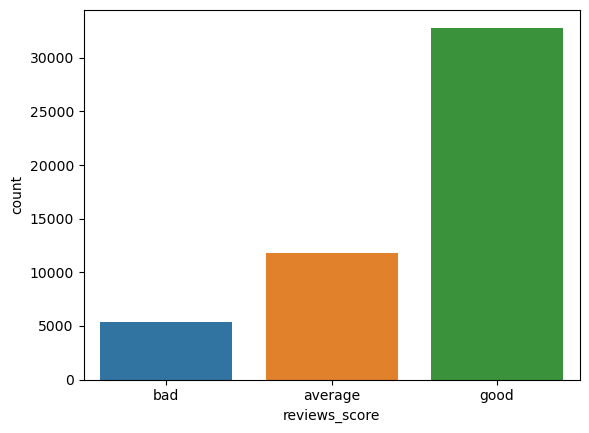

In [33]:
'''Let's now plot the number of good, average, and bad reviews.'''
import seaborn as sns

sns.countplot(x='reviews_score', data=yelp_reviews, hue='reviews_score')

<p style="font-family:Roboto; font-size: 28px; color: magenta"> Creating a Model with Text Inputs Only</p>

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Data preprocessing</p>

In [34]:
'''The first step is to define a function that cleans the textual data.'''
def preprocess_text(sen):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [35]:
'''The text reviews will be cleaned using the preprocess_text function, 
which removes punctuations and numbers from the text.'''
X = []
sentences = list(yelp_reviews["text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = yelp_reviews['reviews_score']

In [36]:
'''We can use the to_categorical method from the keras.utils module. However, first we have to convert
 the text into integer labels using the LabelEncoder function from the sklearn.preprocessing module.'''
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y = label_encoder.fit_transform(y)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [38]:
'''Now we can convert both the training and test labels into one-hot encoded vectors:'''
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [39]:
'''The first step in word embeddings is to convert the words into their corresponding numeric indexes.

To do so, we can use the Tokenizer class from the tensorflow.keras.preprocessing.text module.
'''
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [40]:
'''Sentences can have different lengths, and therefore the sequences returned by the Tokenizer class also consist 
of variable lengths. 
We specify that the maximum length of the sequence will be 200'''
vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [41]:
'''We will use GloVe embeddings to create our feature matrix. In the following script we load the GloVe word embeddings 
and create a dictionary 
that will contain words as keys and their corresponding embedding list as values'''

from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('./data/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [42]:
'''Finally, we will create an embedding matrix where rows will be equal to the number of words in the vocabulary (plus 1). 
The number of columns will be 100 since each word in the GloVe word embeddings that 
we loaded is represented as a 100 dimensional vector.'''
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Using Keras' functional API to create our model</p>

In [43]:
'''We will create a very simple model with one input layer (embedding layer), one LSTM layer with 128 neurons 
and one dense layer that will act as the output layer as well. 
Since we have 3 possible outputs, the number of neurons will be 3 and the activation function will be softmax. 
We will use the categorical_crossentropy as our loss function and adam as the optimization function'''
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(3, activation='softmax')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])



In [44]:
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 200, 100)       │     4,975,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,093,135 (19.43 MB)

 Trainable params: 117,635 (459.51 KB)

 Non-trainable params: 4,975,500 (18.98 MB)

None


In [45]:
'''Finally, lets print the block diagram of our neural network:'''
from keras.utils import plot_model
plot_model(model, to_file='/data/model_plot1.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Train our model</p>

In [46]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - acc: 0.6451 - loss: 0.8923 - val_acc: 0.6651 - val_loss: 0.8409
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 231s 925ms/step - acc: 0.6600 - loss: 0.8441 - val_acc: 0.6650 - val_loss: 0.8419
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 227s 907ms/step - acc: 0.6562 - loss: 0.8473 - val_acc: 0.6649 - val_loss: 0.8401
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 214s 857ms/step - acc: 0.6589 - loss: 0.8421 - val_acc: 0.6649 - val_loss: 0.8368
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 276s 912ms/step - acc: 0.6667 - loss: 0.8278 - val_acc: 0.6651 - val_loss: 0.8409
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 216s 866ms/step - acc: 0.6636 - loss: 0.8342 - val_acc: 0.6660 - val_loss: 0.8350
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 215s 862ms/step - acc: 0.6652 - loss: 0.8318 - val_acc: 0.6710 - val_loss: 0.8253
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 215s 858ms/step - acc: 0.6618 - loss: 0.8394 - val_acc: 0.6704 - val_loss: 0.8257
Epoch 9/10
250/250 ━━━━━━━━

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Evaluate our model</p>

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

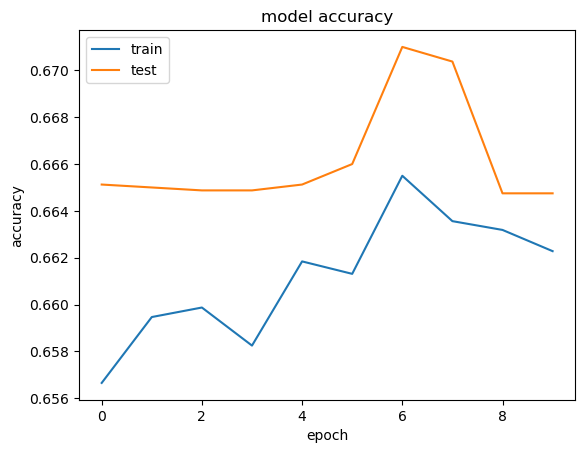

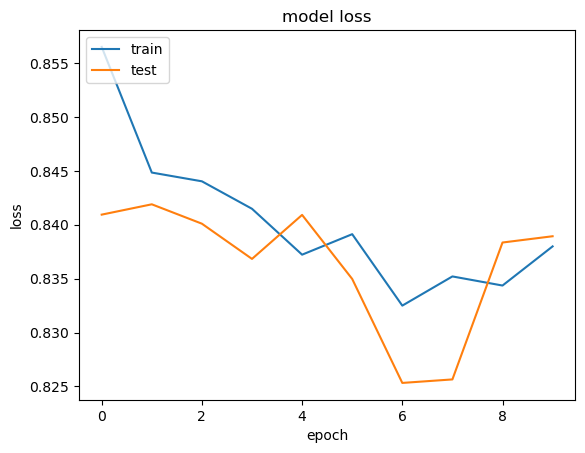

In [48]:
'''Finally, let's plot the values for loss and accuracy for both training and testing sets:'''
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [49]:
'''You can see the lines for both training and testing accuracies and losses are pretty close to each other 
which means that the model is not overfitting.'''

'You can see the lines for both training and testing accuracies and losses are pretty close to each other \nwhich means that the model is not overfitting.'

<p style="font-family:Roboto; font-size: 28px; color: magenta"> Creating a Model with Meta Information Only</p>

In [53]:
yelp_reviews.columns

Index(['user_id', 'review_id', 'text', 'votes.cool', 'business_id',
       'votes.funny', 'stars', 'date', 'type', 'votes.useful',
       'reviews_score'],
      dtype='object')

<Axes: xlabel='reviews_score', ylabel='votes.useful'>

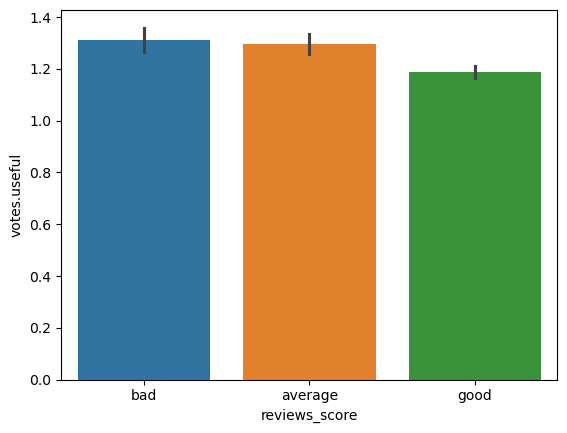

In [54]:
'''In this section, we will create a classification model that uses information 
from the useful, funny, and cool columns of the yelp reviews'''
'''Let's plot the average counts for useful, funny, and cool reviews against the review score.'''
import seaborn as sns
sns.barplot(x='reviews_score', y='votes.useful', data=yelp_reviews, hue='reviews_score')

<Axes: xlabel='reviews_score', ylabel='votes.funny'>

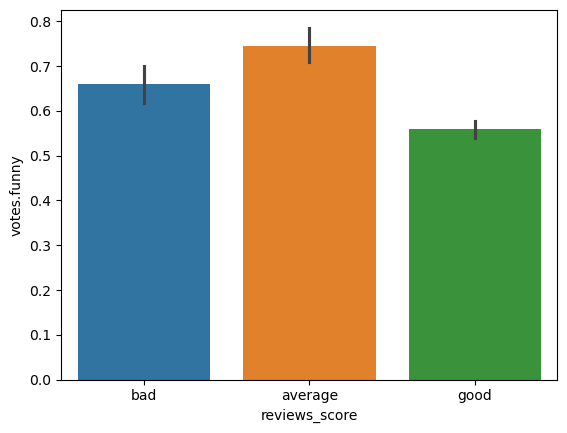

In [55]:
'''Let's now plot the average count for funny reviews:'''
sns.barplot(x='reviews_score', y='votes.funny', data=yelp_reviews, hue='reviews_score')

In [ ]:
'''The output shows that again, the average count for reviews marked as funny is highest for the bad reviews.'''

<Axes: xlabel='reviews_score', ylabel='votes.cool'>

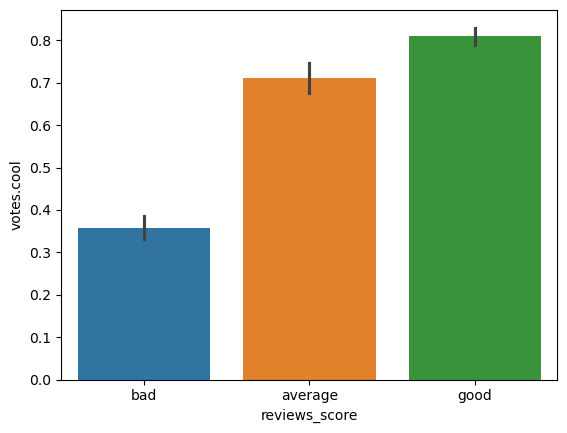

In [56]:
'''Finally, let's plot the average value for the cool column against the reviews_score column.'''
sns.barplot(x='reviews_score', y='votes.cool', data=yelp_reviews, hue='reviews_score')

In [58]:
'''As expected, the average cool count for the good reviews is the highest.'''
'''Let's filter these three columns from our dataset:'''
yelp_reviews_meta = yelp_reviews[['votes.useful', 'votes.funny', 'votes.cool']]

X = yelp_reviews_meta.values

y = yelp_reviews['reviews_score']

In [59]:
'''Next, we will convert our labels into one-hot encoded values and then split our data into train and test sets:'''
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Create our model</p>

In [60]:
'''. Our model will consist of four layers (you can try any number):
the input layer, two dense hidden layers with 10 neurons and ReLU activation functions, 
and finally an output dense layer with 3 neurons and softmax activation function. 
The loss function and optimizer will be categorical_crossentropy and adam, respectively'''
input2 = Input(shape=(3,))
dense_layer_1 = Dense(10, activation='relu')(input2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)
output = Dense(3, activation='softmax')(dense_layer_2)

model = Model(inputs=input2, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [61]:
print(model.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183 (732.00 B)

 Trainable params: 183 (732.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
'''Finally, the block diagram for the model can be created via the following script:'''
from keras.utils import plot_model
plot_model(model, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Train our model</p>

In [63]:
history = model.fit(X_train, y_train, batch_size=16, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 43s 19ms/step - acc: 0.6227 - loss: 0.9190 - val_acc: 0.6647 - val_loss: 0.8218
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - acc: 0.6611 - loss: 0.8243 - val_acc: 0.6651 - val_loss: 0.8209
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - acc: 0.6606 - loss: 0.8242 - val_acc: 0.6658 - val_loss: 0.8178
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - acc: 0.6631 - loss: 0.8196 - val_acc: 0.6664 - val_loss: 0.8182
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - acc: 0.6573 - loss: 0.8291 - val_acc: 0.6665 - val_loss: 0.8176
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - acc: 0.6642 - loss: 0.8204 - val_acc: 0.6672 - val_loss: 0.8176
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - acc: 0.6586 - loss: 0.8238 - val_acc: 0.6668 - val_loss: 0.8180
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - acc: 0.6601 - loss: 0.8240 - val_acc: 0.6664 - val_loss: 0.8170
Epoch 9/10
2000/2000 ━━━━━━━

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Evaluate our model</p>

In [ ]:
'''From the output, you can see that our model doesn't converge and 
accuracy values remain between 66 and 67 across all the epochs.'''
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - acc: 0.6466 - loss: 0.8412
Test Score: 0.8438557386398315
Test Accuracy: 0.6446999907493591


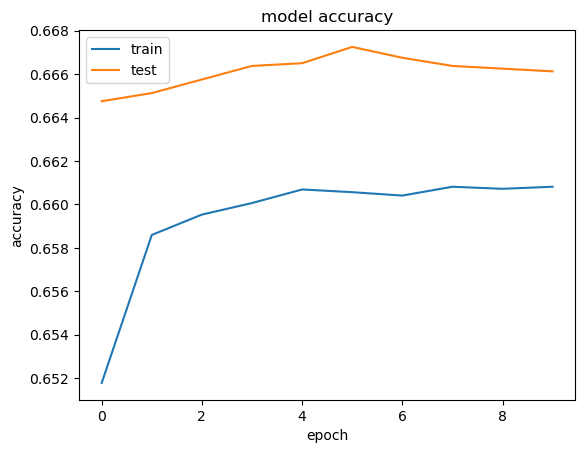

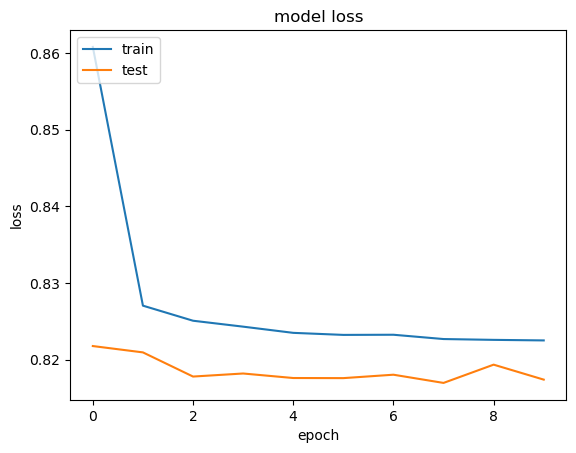

In [67]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [68]:
'''From the output, you can see that accuracy values are relatively lower. 
Hence, we can say that our model is under-fitting. The accuracy can be increased 
by increasing the number of dense layers or by increasing the number of epochs, however I will leave that to you.'''

'From the output, you can see that accuracy values are relatively lower. \nHence, we can say that our model is under-fitting. The accuracy can be increased \nby increasing the number of dense layers or by increasing the number of epochs, however I will leave that to you.'

<p style="font-family:Roboto; font-size: 28px; color: magenta"> Creating a Model with Multiple Inputs</p>

In [69]:
'''What if we want to combine textual information with meta information and use that as input to our model? We can do so using the Keras functional API. 
In this section we will create two sub-models.'''

'What if we want to combine textual information with meta information and use that as input to our model? We can do so using the Keras functional API. \nIn this section we will create two sub-models.'

In [70]:
'''The first submodel will accept textual input in the form of text reviews. 
This submodel will consist of an input shape layer, an embedding layer, and an LSTM layer of 128 neurons. '''

'The first submodel will accept textual input in the form of text reviews. \nThis submodel will consist of an input shape layer, an embedding layer, and an LSTM layer of 128 neurons. '

In [71]:
'''he second submodel will accept input in the form of meta information from the useful, funny, and cool columns. 
The second submodel also consists of three layers. 
An input layer and two dense layers.'''

'he second submodel will accept input in the form of meta information from the useful, funny, and cool columns. \nThe second submodel also consists of three layers. \nAn input layer and two dense layers.'

In [72]:
'''The output from the LSTM layer of the first submodel and the output from the second dense layer of the second submodel
will be concatenated together and will be used as concatenated input to another dense layer with 10 neurons. 
inally, the output dense layer will have three neurons corresponding to each review type.'''

'The output from the LSTM layer of the first submodel and the output from the second dense layer of the second submodel\nwill be concatenated together and will be used as concatenated input to another dense layer with 10 neurons. \ninally, the output dense layer will have three neurons corresponding to each review type.'

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Data preprocessing</p>

In [73]:
# we will divide our data into a feature set and label set, as shown below:
X = yelp_reviews.drop('reviews_score', axis=1)

y = yelp_reviews['reviews_score']

In [74]:
# The X variable contains the feature set, whereas the y variable contains the label set. 
# We need to convert our labels into one-hot encoded vectors.
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [75]:
'''Let's first create preproces_text function that will be used to preprocess our dataset:'''
def preprocess_text(sen):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [76]:
'''As a first step, we will create textual input for the training and test set.'''
X1_train = []
sentences = list(X_train["text"])
for sen in sentences:
    X1_train.append(preprocess_text(sen))

In [77]:
'''Now X1_train contains the textual input for the training set. 
Similarly, the following script preprocess textual input data for test set:'''
X1_test = []
sentences = list(X_test["text"])
for sen in sentences:
    X1_test.append(preprocess_text(sen))

In [78]:
'''Now we need to convert textual input for the training and test sets into numeric form using word embeddings. '''
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)

In [81]:
'''We will again use GloVe word embeddings for creating word vectors:'''
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('./data/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [82]:
yelp_reviews.columns

Index(['user_id', 'review_id', 'text', 'votes.cool', 'business_id',
       'votes.funny', 'stars', 'date', 'type', 'votes.useful',
       'reviews_score'],
      dtype='object')

In [83]:
'''We have preprocessed our textual input. The second input type is the meta information 
in the useful, funny, and cool columns. 
We will filter these columns from the feature set to create meta input for training the algorithms. '''
X2_train = X_train[['votes.useful', 'votes.funny', 'votes.cool']].values
X2_test = X_test[['votes.useful', 'votes.funny', 'votes.cool']].values

In [84]:
'''Let's now create our two input layers. The first input layer will be used to input the textual input and 
the second input layer will be used to input meta information from the three columns.'''
input_1 = Input(shape=(maxlen,))

input_2 = Input(shape=(3,))

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Create the first submodel </p>

In [91]:
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer_1 = LSTM(128)(embedding_layer)

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Create the second submodel </p>

In [92]:
dense_layer_1 = Dense(10, activation='relu')(input_2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Create our final model</p>

In [93]:
concat_layer = Concatenate()([LSTM_Layer_1, dense_layer_2])
dense_layer_3 = Dense(10, activation='relu')(concat_layer)
output = Dense(3, activation='softmax')(dense_layer_3)
model = Model(inputs=[input_1, input_2], outputs=output)

In [94]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 200, 100)  │  4,975,500 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 10)        │         40 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 128)       │    117,248 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 10)        │        110 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 138)       │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 10)        │      1,390 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 3)         │         33 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,094,321 (19.43 MB)

 Trainable params: 118,821 (464.14 KB)

 Non-trainable params: 4,975,500 (18.98 MB)

None


In [95]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Train our model</p>

In [96]:
history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - acc: 0.6429 - loss: 0.8933 - val_acc: 0.6658 - val_loss: 0.8239
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - acc: 0.6626 - loss: 0.8265 - val_acc: 0.6646 - val_loss: 0.8235
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - acc: 0.6590 - loss: 0.8247 - val_acc: 0.6660 - val_loss: 0.8051
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - acc: 0.6650 - loss: 0.7941 - val_acc: 0.7266 - val_loss: 0.6263
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - acc: 0.7240 - loss: 0.6273 - val_acc: 0.7495 - val_loss: 0.5792
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 230s 918ms/step - acc: 0.7504 - loss: 0.5703 - val_acc: 0.7635 - val_loss: 0.5493
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - acc: 0.7657 - loss: 0.5460 - val_acc: 0.7690 - val_loss: 0.5326
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - acc: 0.7825 - loss: 0.5074 - val_acc: 0.7804 - val_loss: 0.5040
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 257s 

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Evaluate our model</p>

In [97]:
score = model.evaluate(x=[X1_test, X2_test], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 151ms/step - acc: 0.7846 - loss: 0.5092
Test Score: 0.5106667280197144
Test Accuracy: 0.7836999893188477


In [ ]:
'''Our test accuracy is 78.36%, which is slightly less than our first model that uses textual input only. 
This shows that meta information in yelp_reviews is not very useful for sentiment prediction.'''

'Our test accuracy is 80.53%, which is slightly less than our first model that uses textual input only. \nThis shows that meta information in yelp_reviews is not very useful for sentiment prediction.'

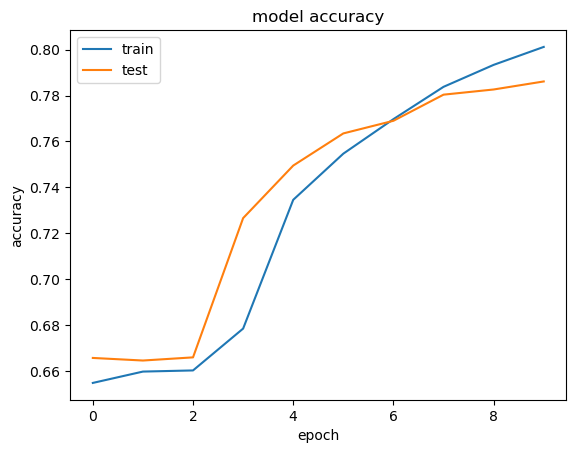

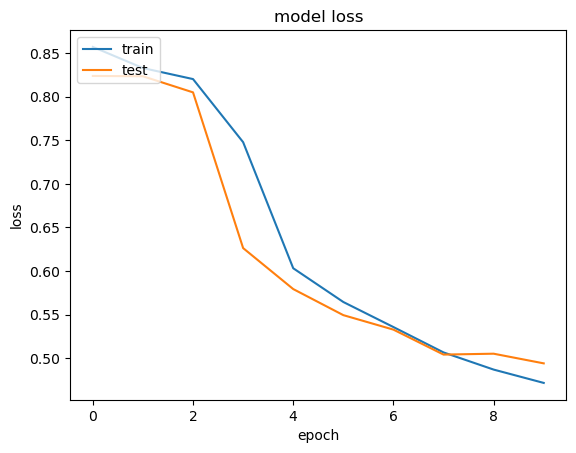

In [99]:
'''Finally, let's now print the loss and accuracy for training and test sets:'''
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()